# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Logistic Boosting</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">LogitBoost algorithm</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

 **Source:** Friedman, J., Trevor Hastie, and R. Tibshirani. Additive Logistic Regression: a Statistical View of Boosting. Algorithm 3.
 * http://www.stanford.edu/~hastie/Papers/AdditiveLogisticRegression/alr.pdf

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = 'is_bad'

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Logistic Boosting (LogitBoost) model</span>

A custom implementation of the famous LogitBoost algorithm.

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss
from scipy.special import expit as sigmoid

class LogisticBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_iter=100, learning_rate=1.0, base_learner_depth=1):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.base_learner_depth = base_learner_depth
        self.predictors = []
        self.loss_dict = []

    def fit(self, X, y):
        # Initialize weights
        w = np.ones(X.shape[0]) / X.shape[0]
        # Initialize predictions
        F = np.zeros(X.shape[0])
        
        for _ in range(self.n_iter):
            # Working response and weights
            p = sigmoid(F) # probability
            z = (y - p) / (p * (1 - p)) # working response
            W = p * (1 - p) # weights
            
            # Fit a regressor (stump) to the working response
            tree = DecisionTreeRegressor(max_depth=self.base_learner_depth)
            tree.fit(X, z, sample_weight=W)
            self.predictors.append(tree)
            
            # Update F
            F += self.learning_rate * tree.predict(X)
            
            # Calculate and store the loss
            loss = log_loss(y, sigmoid(F))
            self.loss_dict.append(loss)
    
    def predict_proba(self, X):
        F = sum(self.learning_rate * predictor.predict(X) for predictor in self.predictors)
        proba = sigmoid(F)
        return np.vstack((1 - proba, proba)).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba > 0.5).astype(int)

Gini train: 89.77%
Gini test: 88.98%


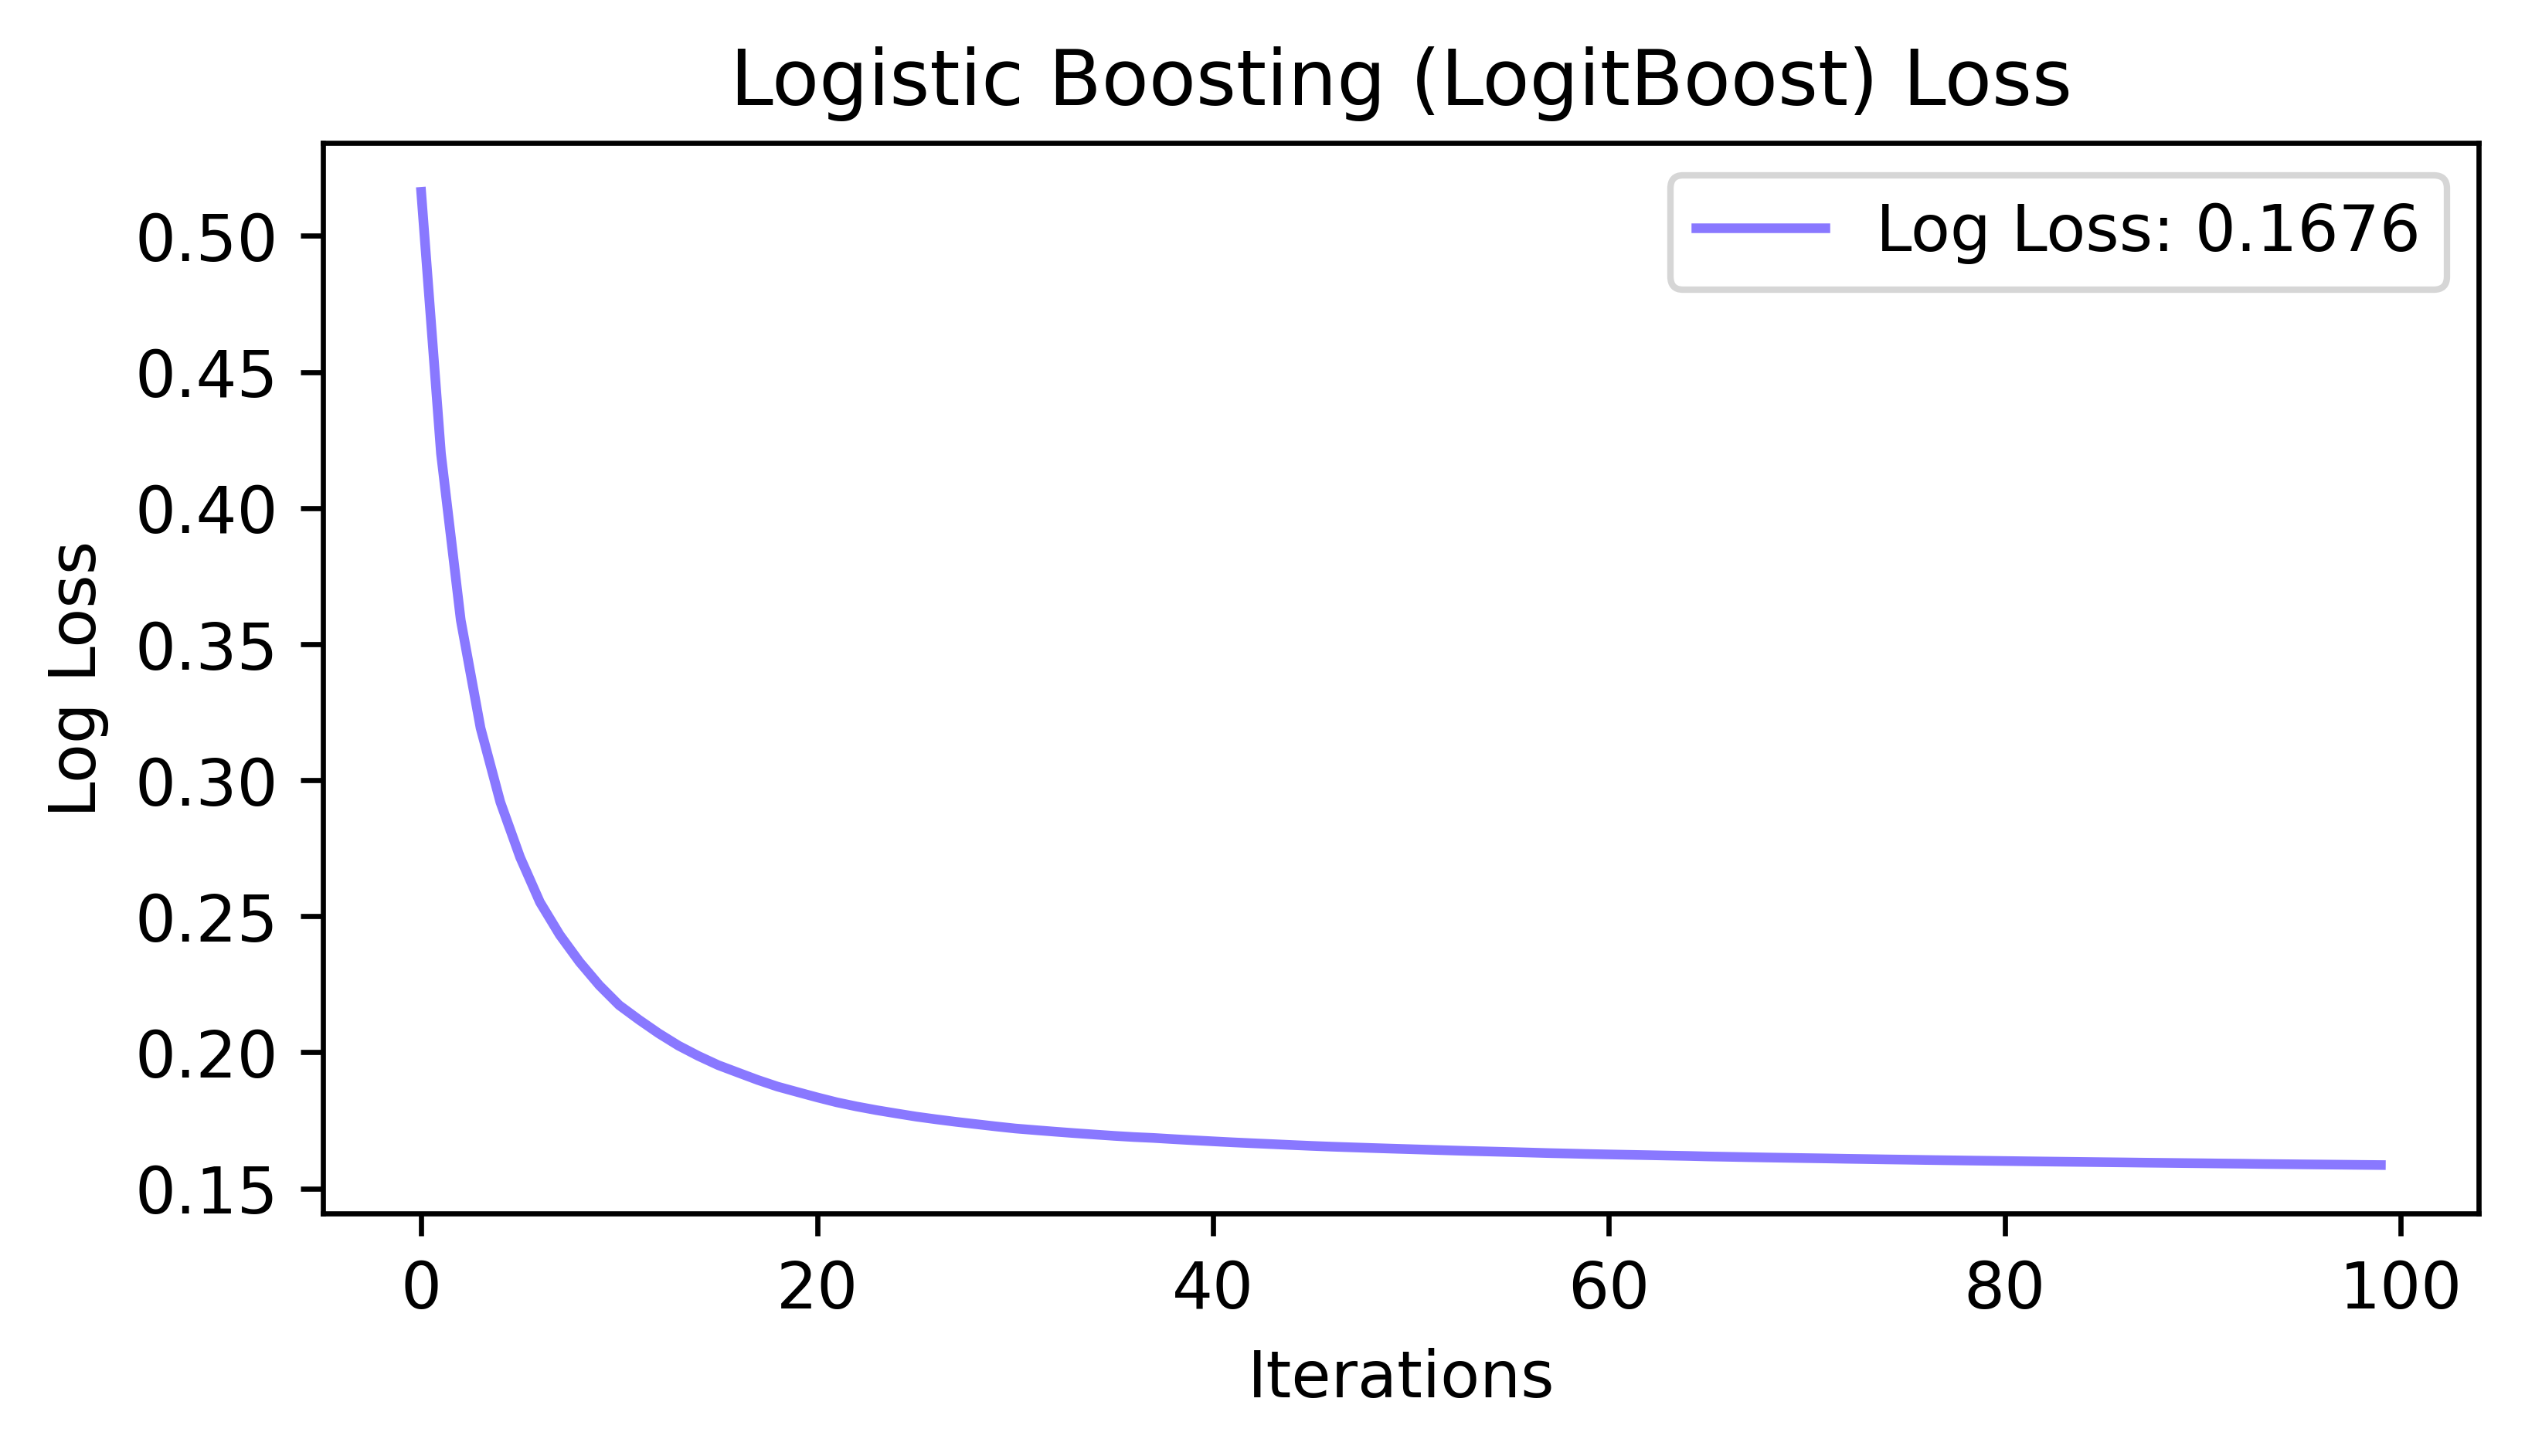

In [16]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

logitboost = LogisticBoostingClassifier(n_iter=100, learning_rate=.3, base_learner_depth=1)
logitboost.fit(X.loc[ix_train], y.loc[ix_train])

gini_train = roc_auc_score(y.loc[ix_train], logitboost.predict_proba(X.loc[ix_train])[:, 1]) * 2 - 1
gini_test = roc_auc_score(y.loc[ix_test], logitboost.predict_proba(X.loc[ix_test])[:, 1]) * 2 - 1

print(f"Gini train: {gini_train:.2%}")
print(f"Gini test: {gini_test:.2%}")

log_loss_score = log_loss(y.loc[ix_test], logitboost.predict_proba(X.loc[ix_test])[:, 1])

plt.figure(figsize=(6, 3), dpi=600)
plt.title("Logistic Boosting (LogitBoost) Loss")
plt.plot(logitboost.loss_dict, color='#8978ff', label=f"Log Loss: {log_loss_score:.4f}")
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()